In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.transforms import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def readAndPreprocess(img_path):
    # Read and convert from BGR to RGB
    img = cv2.imread(img_path)[..., ::-1]
    # Resize
    img = cv2.resize(img, (224, 224))
    # Convert to tensor, normalize and flatten 
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # From ImageNet 
    ])
    img = transform(img).unsqueeze_(0)
    return img

In [3]:

def getDeconvModel(model, input_img, last_layer_index):
    
    layer_list = []
    unpool_indices_list = []

    x = input_img

    for idx, layer in enumerate(model.features):
        if isinstance(layer, torch.nn.Conv2d):
            B, C, H, W = x.shape
            x = layer(x)
            deconv_layer = nn.ConvTranspose2d(layer.out_channels, C, layer.kernel_size, layer.stride, layer.padding)
            deconv_layer.weight = layer.weight
            layer_list.append(deconv_layer)

        if isinstance(layer, torch.nn.ReLU):
            x = layer(x)
            layer_list.append(layer)

        if isinstance(layer, torch.nn.MaxPool2d):
            layer.return_indices = True
            x, unpool_index = layer(x)
            unpool_indices_list.append(unpool_index)
            unpool_layer = torch.nn.MaxUnpool2d(kernel_size=layer.kernel_size, stride=layer.stride,
                                                padding=layer.padding)
            layer_list.append(unpool_layer)
            layer.return_indices = True

        if idx == last_layer_index:
            break

    def deconvNet(y):
        for layer in reversed(layer_list):
            if isinstance(layer, nn.MaxUnpool2d):
                y = layer(y, unpool_indices_list.pop())
            else:
                y = layer(y)
        return y

    return x, deconvNet


In [4]:
model = models.vgg16(pretrained=True).eval()

In [5]:
def getImg(img):
    npimg = img[0].data.numpy()
    npimg = ((npimg - npimg.min()) * 255 / (npimg.max() - npimg.min())).astype('uint8')
    npimg = np.transpose(npimg, (1, 2, 0))

    return npimg

In [13]:
input_img = readAndPreprocess("../../experiments/data/imgs/steth.JPEG")

model = models.vgg16(pretrained=True).eval()

model(input_img)
visualize_layer_indices = []

for i, layer in enumerate(model.features):
    if isinstance(layer, torch.nn.MaxPool2d):
        visualize_layer_indices.append(i)

layerImgs = {}
for layer_max_count in visualize_layer_indices:
    print("layer...%s" % layer_max_count)
    y, deconvNet = getDeconvModel(model, input_img, layer_max_count)
    reproducted_img = deconvNet(y)
    layerImgs[layer_max_count] = getImg(reproducted_img)

layer...4
layer...9
layer...16
layer...23
layer...30


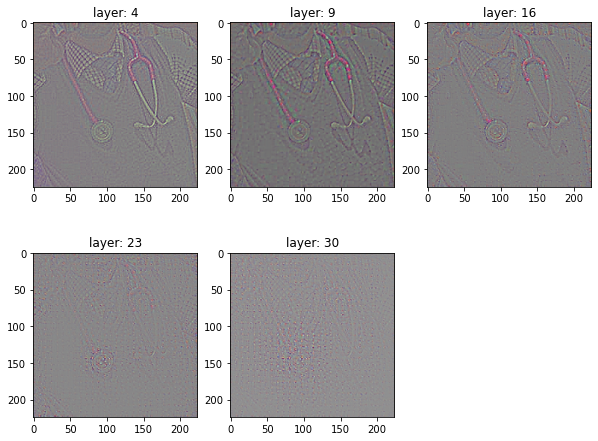

In [14]:
fig = plt.figure(figsize=(10, 12))
cnt = 1
for key in layerImgs:
    fig.add_subplot(3, 3, cnt)
    cnt += 1
    plt.title('layer: ' + str(key))
    plt.imshow(layerImgs[key])
plt.show()